In [1]:
# !pip install patool
# import patoolib
# patoolib.extract_archive("train-resized.zip")
# patoolib.extract_archive("test-resized.zip")

In [9]:
#Imports
!pip3 install tqdm
import numpy as np
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader,Dataset,random_split,WeightedRandomSampler
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
from torchvision.io import read_image
from collections import Counter

In [10]:
#create csv file for test
csv_exist=True
if csv_exist==False:
    img_dir="./test-resized"
    with open('test-name.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        field = ["name"]
        writer.writerow(field)
        for x in os.listdir(img_dir):
            writer.writerow([x])

In [11]:
#Chargement des données
#Définition des classes
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+".jpg")
        image = read_image(img_path)
        #preprocess img
        image=image.float()
        image *= (1.0/image.max())
        label = self.img_labels.iloc[idx, 1]
        label=torch.tensor(float(label)) #preprocess label
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
class CustomImageTestset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_name = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_name.iloc[idx,0])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image



Classe du dataset train+val : {0: 32542, 1: 584}
-------------------------------
Classe du dataset train : [29301   512]
-------------------------------
Taille image train : torch.Size([3, 224, 224]), Label : torch.Size([])
   ----------------------------


/tmp/ipykernel_2976/2048350881.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  plt.imshow(sample[0].T)


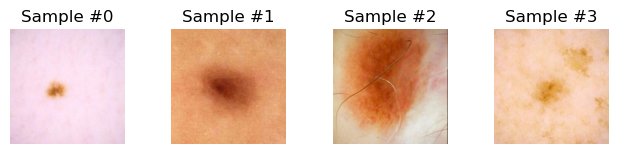

Classe du dataset de validation : {0: 3241, 1: 72}
-------------------------------
Taille image val: torch.Size([3, 224, 224]), Label : torch.Size([])
   ----------------------------


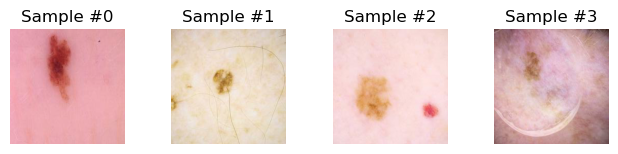

Dataset de test 
-------------------------------
Taille image test: torch.Size([3, 224, 224])
   ----------------------------


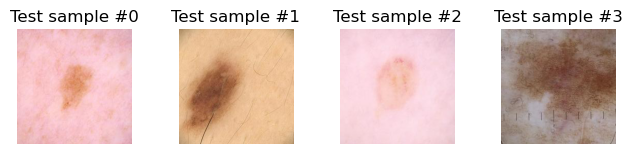

In [12]:
#Chargement des données
#Instanciation des dataloaders

dataset=CustomImageDataset(annotations_file='./train-labels.csv',img_dir='./train-resized')
generator1 = torch.Generator().manual_seed(42)
l=len(dataset)
train_dataset,val_dataset=random_split(dataset,[round(0.9*l), round(0.1*l)], generator=generator1)


test_dataset=CustomImageTestset(annotations_file='./test-name.csv',img_dir='./test-resized')
print(f"Classe du dataset train+val : {dict(Counter(dataset.img_labels.iloc[:, 1]))}\n-------------------------------")

label_train = [train_dataset.dataset.img_labels.iloc[i,1] for i in train_dataset.indices]
class_sample_count = np.array([len(np.where(label_train == t)[0]) for t in np.unique(label_train)])
print(f"Classe du dataset train : {class_sample_count}\n-------------------------------")

for i, sample in enumerate(train_dataset):
    if i == 0:
        print(f"Taille image train : {sample[0].shape}, Label : {sample[1].shape}\n   ----------------------------")
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0].T)
    if i == 3:
        plt.show()
        break
print(f"Classe du dataset de validation : {dict(Counter(val_dataset.dataset.img_labels.iloc[i,1] for i in val_dataset.indices))}\n-------------------------------")
for i, sample in enumerate(val_dataset):
    if i == 0:
        print(f"Taille image val: {sample[0].shape}, Label : {sample[1].shape}\n   ----------------------------")
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0].T)
    if i == 3:
        plt.show()
        break

print(f"Dataset de test \n-------------------------------")
for i, sample in enumerate(test_dataset):
    if i == 0:
        print(f"Taille image test: {sample.shape}\n   ----------------------------")
    ay = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ay.set_title('Test sample #{}'.format(i))
    ay.axis('off')
    plt.imshow(sample.T)
    if i == 3:
        plt.show()
        break

In [13]:
#Mise en forme des données

batch_size = 64

#distribue les classes dans chaque sample
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in label_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight),replacement=True)
samp=False
# Create data loaders.
if samp==True:
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=2,sampler=sampler)
else:
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True,num_workers=2)
val_dataloader=DataLoader(val_dataset, batch_size=batch_size,shuffle=True,num_workers=2)

for X,y in train_dataloader:
    print(f"Classe du batch : {np.array([len(torch.where(y == t)[0]) for t in torch.unique(y)])}\n-------------------------------")
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Classe du batch : [64]
-------------------------------
Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.float32


In [14]:
# Création du modèle
import torchvision.models as models #import resnet18, ResNet18_Weights
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

# Define model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_labels =1;
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*224*224, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = models.resnet18(pretrained=True)
model= model.cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model.fc = model.fc.cuda()  if device=="cuda" else net.fc
# print(model)

Using cuda device


In [16]:
#défini la fonction de perte et l'optimiseur
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
#training
epochs=5
print(f"Batch size : {len(train_dataloader)}\n-------------------------------")
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    size = len(train_dataset)
    model.train()
    for batch, (X, y) in tqdm(enumerate(train_dataloader)):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
print("Done!")


Batch size : 466
-------------------------------
Epoch 1
-------------------------------


1it [00:00,  1.86it/s]

loss: 0.826474  [   64/29813]


101it [00:20,  4.02it/s]

loss: 0.037996  [ 6464/29813]


201it [00:39,  4.00it/s]

loss: 0.025031  [12864/29813]


301it [00:59,  4.01it/s]

loss: 0.075855  [19264/29813]


401it [01:19,  3.98it/s]

loss: 0.128595  [25664/29813]


466it [01:32,  5.06it/s]

In [ ]:
#val

val_loss = 0.0
correct_predictions = 0
total_samples = 0
total_samples_0 = 0
total_samples_1 = 0
correct_predictions_0 = 0
correct_predictions_1 = 0
size = len(val_dataset)
num_batches = len(val_dataloader)
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    for val_batch, (val_X, val_y) in tqdm(enumerate(val_dataloader)):
        val_X, val_y = val_X.to(device), val_y.to(device)

        val_pred = model(val_X)
        val_loss += loss_fn(val_pred, val_y).item()

        _, predicted_labels = torch.max(val_pred, 1)
        correct_predictions_0 += ((val_y == 0) & (predicted_labels == 0)).sum().item()
        correct_predictions_1 += ((val_y == 1) & (predicted_labels == 1)).sum().item()

        # Calculate accuracy for each class
        total_samples_0 += (val_y == 0).sum().item()
        total_samples_1 += (val_y == 1).sum().item()

accuracy_0 = correct_predictions_0 / total_samples_0
accuracy_1 = correct_predictions_1 / total_samples_1

avg_val_loss = val_loss / (val_batch + 1)
print(f"Validation loss: {avg_val_loss:.4f}")
# Display class-wise accuracy
print(f"        Accuracy for class 0: {accuracy_0:.4f}    class 1: {accuracy_1:.4f}")
print()


In [28]:
#test
size = len(dataloader.dataset)
num_batches = len(dataloader)
model.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred.squeeze(), y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

NameError: name 'dataloader' is not defined